- Volatility: Mức biến động (Standard deviation)
- Vị thế: gồm Long (Mua) và Short (Bán)

In [ ]:
# Cell 1: Import thư viện

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Hiển thị đồ thị trong notebook
%matplotlib inline

# Thư mục chứa file CSV (nếu notebook và CSV cùng thư mục thì để ".")
DATA_DIR = Path(".")

In [ ]:
# Cell 2: Hàm đọc 1 file CSV cổ phiếu intraday (15 phút)

def load_intraday_stock(csv_path: Path):
    """
    Đọc 1 file CSV intraday có cột: time, open, high, low, close, volume.
    Trả về DataFrame index theo datetime, đã sort tăng dần.
    """
    df = pd.read_csv(csv_path, index_col='time')
    
    # Ép kiểu numeric phòng khi có string
    for col in ["open", "high", "low", "close", "volume"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    
    # Bỏ dòng bị NaN toàn bộ
    df = df.dropna(how="all")
    return df

# Map mã cổ phiếu ↔ file CSV
symbol_to_file = {
    "ACB": "ACB_cleaned.csv",
    "BID": "BID_cleaned.csv",
    "MBB": "MBB_cleaned.csv",
    "CTG": "CTG_cleaned.csv",
    "TCB": "TCB_cleaned.csv",
    "VCB": "VCB_cleaned.csv"
}

# Đọc tất cả cổ phiếu vào dict
intraday_data = {}
for symbol, fname in symbol_to_file.items():
    path = DATA_DIR / fname
    df = load_intraday_stock(path)
    intraday_data[symbol] = df

# Kiểm tra 1 mã bất kỳ
intraday_data["ACB"].head()

,open,high,low,close,volume
time,,,,,
2023-09-11 09:15:00,16.00,16.07,15.97,15.97,366500
2023-09-11 09:30:00,15.97,16.00,15.97,16.00,239600
2023-09-11 09:45:00,16.00,16.04,15.93,15.97,498600
2023-09-11 10:00:00,16.00,16.00,15.90,15.93,622400
2023-09-11 10:15:00,15.93,15.97,15.90,15.97,288300


## Biểu đồ Giá Đóng Cửa theo Thời Gian

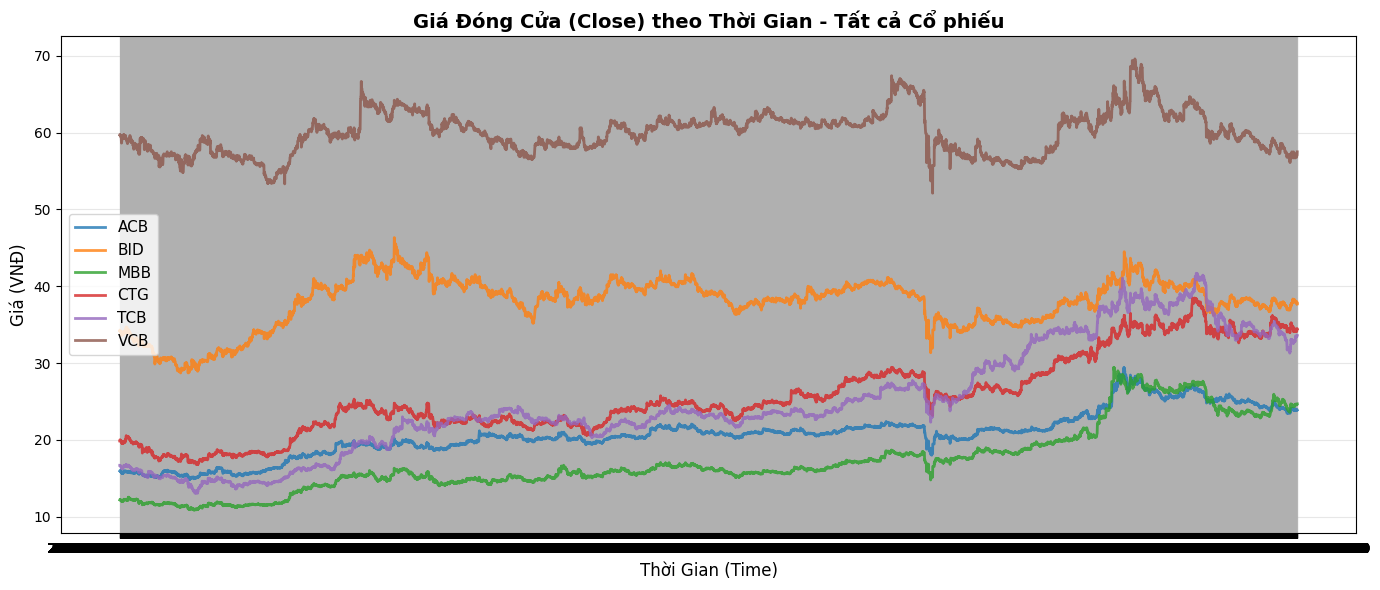

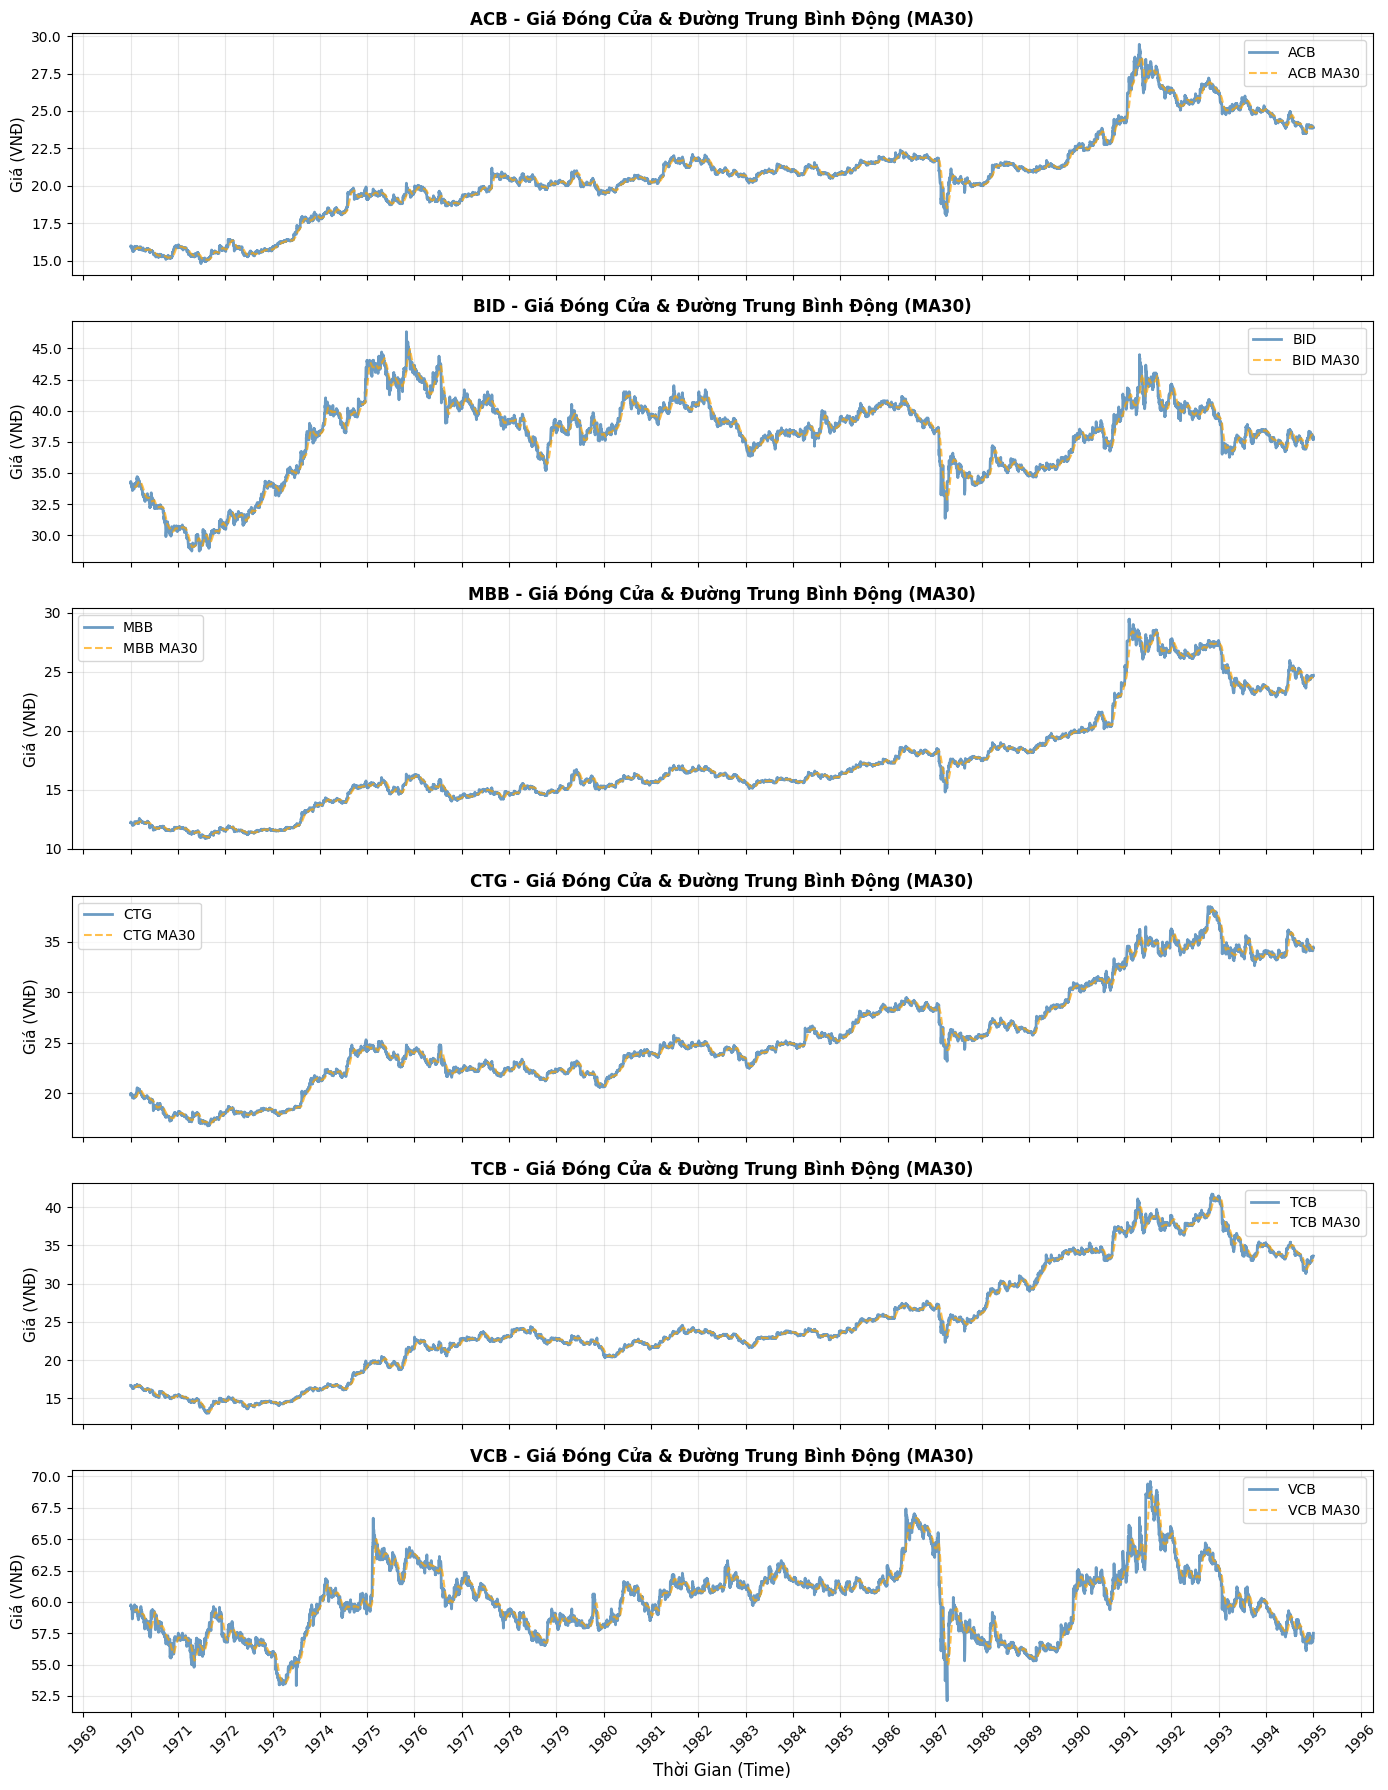

BẢNG THỐNG KÊ GIÁ ĐÓNG CỬA (CLOSE)
      count   mean   std    min    25%    50%    75%    max  Range  CV (%)
ACB  9133.0  20.71  2.96  14.81  19.37  20.70  21.81  29.45  14.64   14.28
BID  9133.0  37.94  3.21  28.72  36.15  38.50  40.15  46.34  17.62    8.47
MBB  9133.0  17.23  4.36  10.86  14.78  16.03  18.54  29.45  18.59   25.31
CTG  9133.0  25.55  5.16  16.79  22.15  24.55  28.46  38.48  21.69   20.21
TCB  9133.0  24.85  7.15  13.04  21.19  23.28  29.81  41.70  28.66   28.78
VCB  9133.0  60.03  2.72  52.12  57.98  60.17  61.65  69.60  17.48    4.53

CHI TIẾT TỪNG CỔ PHIẾU

ACB:
  Giá cao nhất: $29.45
  Giá thấp nhất: $14.81
  Giá trung bình: $20.71
  Giá cuối kỳ: $23.90
  Giá đầu kỳ: $15.97
  Thay đổi: $7.93 (49.66%)
  Độ lệch chuẩn: $2.96
  Hệ số biến động: 14.28%

BID:
  Giá cao nhất: $46.34
  Giá thấp nhất: $28.72
  Giá trung bình: $37.94
  Giá cuối kỳ: $37.70
  Giá đầu kỳ: $34.23
  Thay đổi: $3.47 (10.14%)
  Độ lệch chuẩn: $3.21
  Hệ số biến động: 8.47%

MBB:
  Giá cao nhất: $

In [12]:
# Cell 13: Vẽ biểu đồ đường giá đóng cửa (close) theo thời gian (time) cho tất cả cổ phiếu

# Import thư viện cần thiết cho định dạng ngày tháng
import matplotlib.dates as mdates

# Tạo bảng giá đóng cửa nếu chưa có
close_prices = pd.DataFrame({symbol: df["close"] for symbol, df in intraday_data.items()})
close_prices = close_prices.dropna(how="any")

fig, ax = plt.subplots(figsize=(14, 6))

# Vẽ đường cho từng cổ phiếu
for symbol in close_prices.columns:
    ax.plot(close_prices.index, close_prices[symbol],
            label=symbol, linewidth=2, alpha=0.8)

ax.set_title('Giá Đóng Cửa (Close) theo Thời Gian - Tất cả Cổ phiếu', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Thời Gian (Time)', fontsize=12)
ax.set_ylabel('Giá (VNĐ)', fontsize=12)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)

# Định dạng trục x để hiển thị năm
'''
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)'''

plt.tight_layout()
plt.show()

# =====================================
# 2) VẼ BIỂU ĐỒ RIÊNG BIỆT CHO TỪNG CỔ PHIẾU
# =====================================

num_stocks = len(close_prices.columns)
fig, axes = plt.subplots(num_stocks, 1, figsize=(14, 3 * num_stocks), sharex=True)

# Đảm bảo axes là list
if num_stocks == 1:
    axes = [axes]

for idx, symbol in enumerate(close_prices.columns):
    ax = axes[idx]
    
    ax.plot(close_prices.index, close_prices[symbol], 
            label=symbol, linewidth=2, color='steelblue', alpha=0.8)
    
    # Thêm đường trung bình động 30 ngày
    ma30 = close_prices[symbol].rolling(30).mean()
    ax.plot(close_prices.index, ma30, 
            label=f'{symbol} MA30', linewidth=1.5, 
            linestyle='--', color='orange', alpha=0.7)
    
    ax.set_title(f'{symbol} - Giá Đóng Cửa & Đường Trung Bình Động (MA30)', 
                 fontsize=12, fontweight='bold')
    ax.set_ylabel('Giá (VNĐ)', fontsize=11)
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)

# Định dạng trục x cho chart dưới cùng
axes[-1].set_xlabel('Thời Gian (Time)', fontsize=12)
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axes[-1].xaxis.set_major_locator(mdates.YearLocator())
plt.setp(axes[-1].xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

# =====================================
# 3) BẢNG THỐNG KÊ GIÁ CLOSE
# =====================================

print("=" * 80)
print("BẢNG THỐNG KÊ GIÁ ĐÓNG CỬA (CLOSE)")
print("=" * 80)

stats_close = close_prices.describe().T

# Thêm các thống kê bổ sung
stats_close['Range'] = stats_close['max'] - stats_close['min']
stats_close['CV (%)'] = (stats_close['std'] / stats_close['mean']) * 100  # Coefficient of Variation

print(stats_close.round(2))

print("\n" + "=" * 80)
print("CHI TIẾT TỪNG CỔ PHIẾU")
print("=" * 80)

for symbol in close_prices.columns:
    prices = close_prices[symbol]
    print(f"\n{symbol}:")
    print(f"  Giá cao nhất: ${prices.max():.2f}")
    print(f"  Giá thấp nhất: ${prices.min():.2f}")
    print(f"  Giá trung bình: ${prices.mean():.2f}")
    print(f"  Giá cuối kỳ: ${prices.iloc[-1]:.2f}")
    print(f"  Giá đầu kỳ: ${prices.iloc[0]:.2f}")
    print(f"  Thay đổi: ${prices.iloc[-1] - prices.iloc[0]:.2f} ({((prices.iloc[-1] / prices.iloc[0]) - 1) * 100:.2f}%)")
    print(f"  Độ lệch chuẩn: ${prices.std():.2f}")
    print(f"  Hệ số biến động: {(prices.std() / prices.mean()) * 100:.2f}%")

print("\n" + "=" * 80)

In [3]:
# Cell 4: Tạo bảng giá đóng cửa cho tất cả cổ phiếu (GIỮ NGUYÊN 15 PHÚT)

# Tạo DataFrame chứa giá close của tất cả cổ phiếu (15 phút)
close_prices = pd.DataFrame({symbol: df["close"] for symbol, df in intraday_data.items()})

# Chỉ giữ các timestamp mà TẤT CẢ cổ phiếu đều có dữ liệu (không có NaN)
close_prices = close_prices.dropna(how="any")

print(f"✅ Kết quả close_prices (15 phút):")
print(f"Shape: {close_prices.shape} (timestamp x mã)")
print(f"Khoảng thời gian: {close_prices.index.min()} → {close_prices.index.max()}")
print(f"Số timestamp: {len(close_prices)}")
print(f"Tần suất: 15 phút")

close_prices.tail()

✅ Kết quả close_prices (15 phút):
Shape: (8975, 3) (timestamp x mã)
Khoảng thời gian: 2023-09-11 09:15:00 → 2025-12-05 14:45:00
Số timestamp: 8975
Tần suất: 15 phút


,ACB,BID,MBB
time,,,
2025-12-05 13:30:00,24.55,38.10,25.30
2025-12-05 13:45:00,24.50,38.10,25.30
2025-12-05 14:00:00,24.50,38.00,25.20
2025-12-05 14:15:00,24.40,37.85,25.20
2025-12-05 14:45:00,24.35,37.80,25.15


In [4]:
# Cell 5: Tính log-return daily

log_returns = np.log(close_prices / close_prices.shift(1))
log_returns = log_returns.dropna(how="all")

log_returns.tail()

,ACB,BID,MBB
time,,,
2025-12-05 13:30:00,0.002039,0.000000,0.003960
2025-12-05 13:45:00,-0.002039,0.000000,0.000000
2025-12-05 14:00:00,0.000000,-0.002628,-0.003960
2025-12-05 14:15:00,-0.004090,-0.003955,0.000000
2025-12-05 14:45:00,-0.002051,-0.001322,-0.001986


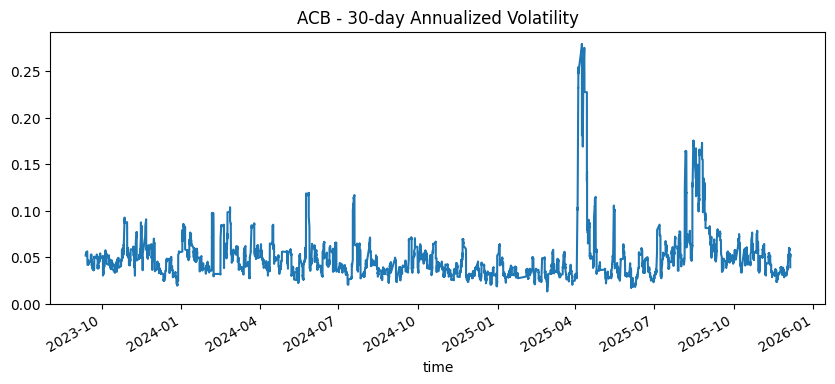

In [5]:
# Ví dụ: volatility 30 ngày của ACB (annualized)

WINDOW = 30
TRADING_DAYS = 252  # giả định

acb_vol_30d = log_returns["ACB"].rolling(WINDOW).std() * np.sqrt(TRADING_DAYS)

acb_vol_30d.plot(figsize=(10, 4), title="ACB - 30-day Annualized Volatility")
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_22452\796072413.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  periodic_close = close_prices.resample(freq).last().dropna(how="all")


Momentum (tháng) - 2 long / 2 short
total_return: -0.1061
annualized_return: -0.0486
annualized_volatility: 0.1674
sharpe: -0.2906
max_drawdown: -0.1779


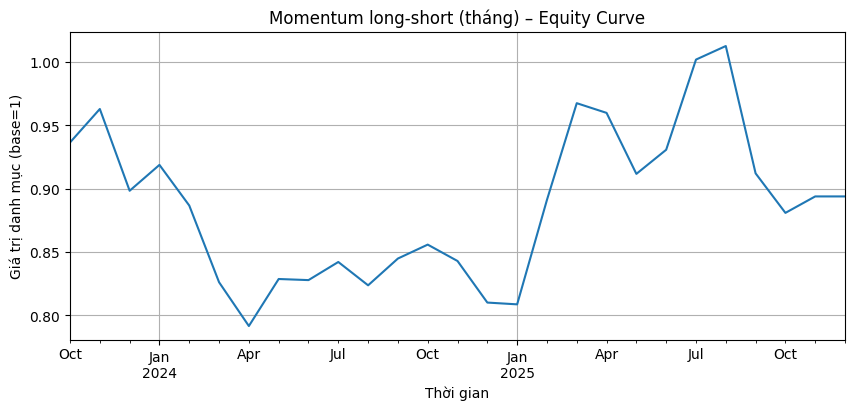

In [8]:
# Cell 7: Cross-sectional momentum theo tháng cho 6 bank

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def build_periodic_close_and_return(close_prices: pd.DataFrame, freq: str = "M"):
    """
    Resample giá đóng cửa daily sang chu kỳ (tháng/quý):
    - freq = 'M' (month-end), 'Q' (quarter-end)
    """
    periodic_close = close_prices.resample(freq).last().dropna(how="all")
    periodic_ret = periodic_close.pct_change().dropna(how="all")
    return periodic_close, periodic_ret


def momentum_long_short_backtest(periodic_ret: pd.DataFrame,
                                 top_n: int = 2,
                                 bottom_n: int = 2,
                                 periods_per_year: int = 12):
    """
    Backtest chiến lược:
    - Cuối kỳ t: rank performance kỳ t, chọn long/short
    - Giữ danh mục trong kỳ t+1
    - periodic_ret: DataFrame return theo chu kỳ (hàng = thời điểm, cột = mã)
    """
    idx = periodic_ret.index
    cols = periodic_ret.columns

    # Ma trận tín hiệu long/short tại THỜI ĐIỂM tạo tín hiệu
    signals_long = pd.DataFrame(False, index=idx, columns=cols)
    signals_short = pd.DataFrame(False, index=idx, columns=cols)

    for date, row in periodic_ret.iterrows():
        row_clean = row.dropna()
        if len(row_clean) < top_n + bottom_n:
            continue

        # Sort giảm dần theo hiệu suất
        sorted_syms = row_clean.sort_values(ascending=False)

        long_syms = sorted_syms.index[:top_n]
        short_syms = sorted_syms.index[-bottom_n:]

        signals_long.loc[date, long_syms] = True
        signals_short.loc[date, short_syms] = True

    # Return kỳ t+1 (để áp vào tín hiệu kỳ t)
    future_ret = periodic_ret.shift(-1)

    long_count = signals_long.sum(axis=1).replace(0, np.nan)
    short_count = signals_short.sum(axis=1).replace(0, np.nan)

    long_port = (signals_long * future_ret).sum(axis=1) / long_count
    short_port = (signals_short * future_ret).sum(axis=1) / short_count

    # Lợi nhuận chiến lược long-short
    strategy_ret = long_port - short_port
    strategy_ret = strategy_ret.dropna()

    if len(strategy_ret) == 0:
        raise ValueError("Không đủ dữ liệu để backtest momentum.")

    # Equity curve (bắt đầu từ 1.0)
    cum_curve = (1 + strategy_ret).cumprod()

    # Thống kê performance
    total_return = cum_curve.iloc[-1] - 1
    years = len(strategy_ret) / periods_per_year
    ann_return = cum_curve.iloc[-1]**(1 / years) - 1 if years > 0 else np.nan
    ann_vol = strategy_ret.std() * np.sqrt(periods_per_year)
    sharpe = ann_return / ann_vol if ann_vol > 0 else np.nan

    running_max = cum_curve.cummax()
    drawdown = cum_curve / running_max - 1
    max_dd = drawdown.min()

    stats = {
        "total_return": total_return,
        "annualized_return": ann_return,
        "annualized_volatility": ann_vol,
        "sharpe": sharpe,
        "max_drawdown": max_dd,
    }
    return strategy_ret, cum_curve, stats


# ======================
# Chạy momentum theo THÁNG
# ======================

# Tạo dữ liệu theo tháng
monthly_close, monthly_ret = build_periodic_close_and_return(close_prices, freq="M")

# Backtest: long 1 mã tốt nhất, short 1 mã tệ nhất (chỉ có 3 mã)
strategy_ret_m, cum_curve_m, stats_m = momentum_long_short_backtest(
    monthly_ret,
    top_n=1,
    bottom_n=1,
    periods_per_year=12
)

# In thống kê
print("Momentum (tháng) - 2 long / 2 short")
for k, v in stats_m.items():
    print(f"{k}: {v:.4f}")

# Vẽ equity curve
cum_curve_m.plot(figsize=(10, 4), title="Momentum long-short (tháng) – Equity Curve")
plt.xlabel("Thời gian")
plt.ylabel("Giá trị danh mục (base=1)")
plt.grid(True)
plt.show()


In [9]:
def check_cointegration(stock_y, stock_x, data):
    """
    Thực hiện Engle-Granger Test:
    1. Hồi quy Y = alpha + beta * X
    2. Tính Spread (Residuals)
    3. Kiểm định ADF trên Spread
    """
    y = data[stock_y]
    x = data[stock_x]
    
    # 1. Hồi quy OLS để tìm Hedge Ratio
    x_with_const = sm.add_constant(x)
    model = sm.OLS(y, x_with_const).fit()
    alpha, beta = model.params[0], model.params[1]
    
    # 2. Tính Spread
    spread = y - (alpha + beta * x)
    
    # 3. ADF Test
    # Null Hypothesis (H0): Spread không dừng (Non-stationary) - Không cointegrated
    # Alt Hypothesis (H1): Spread dừng (Stationary) - Có cointegrated
    adf_result = adfuller(spread)
    p_value = adf_result[1]
    
    return p_value, beta, alpha

print("Kiểm tra Cointegration cho các cặp (P-value < 0.05 là tốt):")
# Chỉ sử dụng các cặp có trong close_prices: ACB, BID, MBB
pairs_to_test = [("ACB", "BID"), ("MBB", "BID"), ("ACB", "MBB")]

for y, x in pairs_to_test:
    p_val, beta, alpha = check_cointegration(y, x, close_prices)
    status = "COINTEGRATED (Thích hợp Pair Trading)" if p_val < 0.05 else "Không cointegrated"
    print(f"{y} - {x}: P-value = {p_val:.4f} -> {status}")

Kiểm tra Cointegration cho các cặp (P-value < 0.05 là tốt):


C:\Users\Admin\AppData\Local\Temp\ipykernel_22452\2558906420.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha, beta = model.params[0], model.params[1]


ACB - BID: P-value = 0.7406 -> Không cointegrated


C:\Users\Admin\AppData\Local\Temp\ipykernel_22452\2558906420.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha, beta = model.params[0], model.params[1]


MBB - BID: P-value = 0.9655 -> Không cointegrated


C:\Users\Admin\AppData\Local\Temp\ipykernel_22452\2558906420.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha, beta = model.params[0], model.params[1]


ACB - MBB: P-value = 0.0649 -> Không cointegrated


Pairs trading ACB-BID
alpha: 1.3666
beta: 0.5081
total_return: 0.1096
annualized_return: 0.0029
annualized_volatility: 0.0343
sharpe: 0.0852
max_drawdown: -0.1459


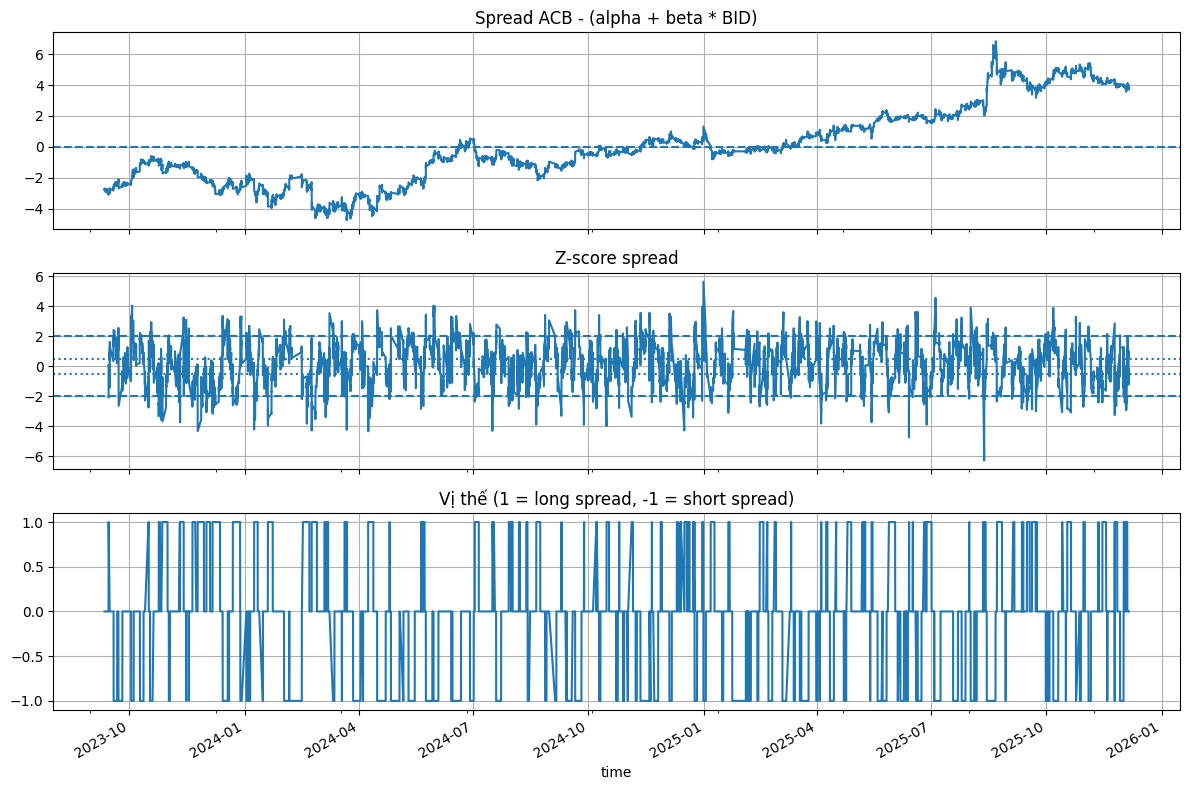

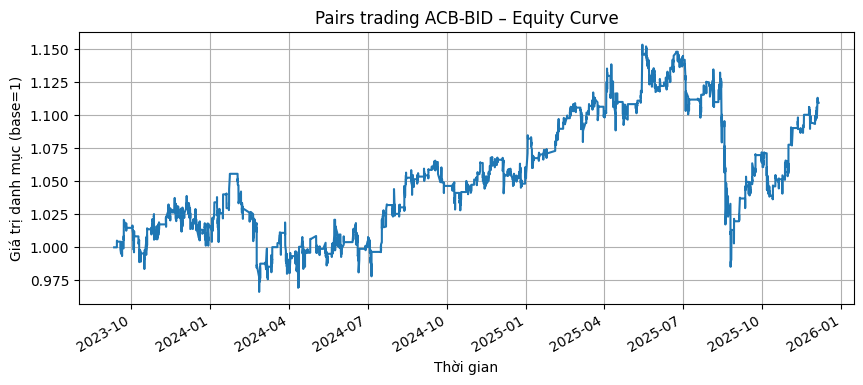

In [10]:
# Cell 8: Pairs trading cho 1 cặp cổ phiếu bank

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def pairs_trading_backtest(close_prices: pd.DataFrame,
                           stock_y: str,
                           stock_x: str,
                           lookback: int = 60,
                           entry_z: float = 2.0,
                           exit_z: float = 0.5):
    """
    Backtest pairs trading:
    - stock_y: cổ phiếu chính (y)
    - stock_x: cổ phiếu hedge (x)
    - lookback: cửa sổ rolling để tính mean/std spread
    """
    data = close_prices[[stock_y, stock_x]].dropna()
    y = data[stock_y]
    x = data[stock_x]

    # OLS: y = alpha + beta * x
    beta, alpha = np.polyfit(x.values, y.values, 1)

    # Spread & z-score
    spread = y - (alpha + beta * x)
    spread_mean = spread.rolling(lookback).mean()
    spread_std = spread.rolling(lookback).std()
    zscore = (spread - spread_mean) / spread_std

    # Vị thế: 1 = long spread, -1 = short spread, 0 = flat
    position = pd.Series(0.0, index=data.index)

    for t in range(lookback, len(data)):
        date = data.index[t]
        prev_z = zscore.iloc[t - 1]
        prev_pos = position.iloc[t - 1]

        if prev_pos == 0:
            # Chưa có vị thế, kiểm tra điều kiện vào lệnh
            if prev_z > entry_z:
                position.iloc[t] = -1.0  # short spread
            elif prev_z < -entry_z:
                position.iloc[t] = 1.0   # long spread
            else:
                position.iloc[t] = 0.0

        elif prev_pos == 1.0:
            # Đang long spread, thoát khi |z| < exit_z
            if abs(prev_z) < exit_z:
                position.iloc[t] = 0.0
            else:
                position.iloc[t] = 1.0

        elif prev_pos == -1.0:
            # Đang short spread, thoát khi |z| < exit_z
            if abs(prev_z) < exit_z:
                position.iloc[t] = 0.0
            else:
                position.iloc[t] = -1.0

    # Log return cho từng leg
    log_ret_y = np.log(y / y.shift(1))
    log_ret_x = np.log(x / x.shift(1))
    spread_log_ret = log_ret_y - beta * log_ret_x

    # Lợi nhuận chiến lược (dùng vị thế ngày t-1 để tránh look-ahead)
    strategy_ret = position.shift(1) * spread_log_ret
    strategy_ret = strategy_ret.dropna()

    if len(strategy_ret) == 0:
        raise ValueError("Không đủ dữ liệu / giao dịch cho pairs trading.")

    # Equity curve
    cum_curve = (1 + strategy_ret).cumprod()

    TRADING_DAYS = 252
    total_return = cum_curve.iloc[-1] - 1
    years = len(strategy_ret) / TRADING_DAYS
    ann_return = cum_curve.iloc[-1]**(1 / years) - 1 if years > 0 else np.nan
    ann_vol = strategy_ret.std() * np.sqrt(TRADING_DAYS)
    sharpe = ann_return / ann_vol if ann_vol > 0 else np.nan

    running_max = cum_curve.cummax()
    drawdown = cum_curve / running_max - 1
    max_dd = drawdown.min()

    stats = {
        "alpha": alpha,
        "beta": beta,
        "total_return": total_return,
        "annualized_return": ann_return,
        "annualized_volatility": ann_vol,
        "sharpe": sharpe,
        "max_drawdown": max_dd,
    }

    result = {
        "spread": spread,
        "zscore": zscore,
        "position": position,
        "strategy_ret": strategy_ret,
        "cum_curve": cum_curve,
        "stats": stats,
    }
    return result


# ======================
# Chạy pairs trading cho 1 cặp ví dụ: VCB - CTG
# ======================

res_pairs = pairs_trading_backtest(
    close_prices,
    stock_y="ACB",
    stock_x="BID",
    lookback=60,
    entry_z=2.0,
    exit_z=0.5
)

print("Pairs trading ACB-BID")
for k, v in res_pairs["stats"].items():
    print(f"{k}: {v:.4f}")

# Vẽ spread + z-score + vị thế
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

res_pairs["spread"].plot(ax=axes[0], title="Spread ACB - (alpha + beta * BID)")
axes[0].axhline(0, linestyle="--")
axes[0].grid(True)

res_pairs["zscore"].plot(ax=axes[1], title="Z-score spread")
axes[1].axhline(2.0, linestyle="--")
axes[1].axhline(-2.0, linestyle="--")
axes[1].axhline(0.5, linestyle=":")
axes[1].axhline(-0.5, linestyle=":")
axes[1].grid(True)

res_pairs["position"].plot(ax=axes[2], title="Vị thế (1 = long spread, -1 = short spread)")
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Equity curve
res_pairs["cum_curve"].plot(figsize=(10, 4), title="Pairs trading ACB-BID – Equity Curve")
plt.xlabel("Thời gian")
plt.ylabel("Giá trị danh mục (base=1)")
plt.grid(True)
plt.show()

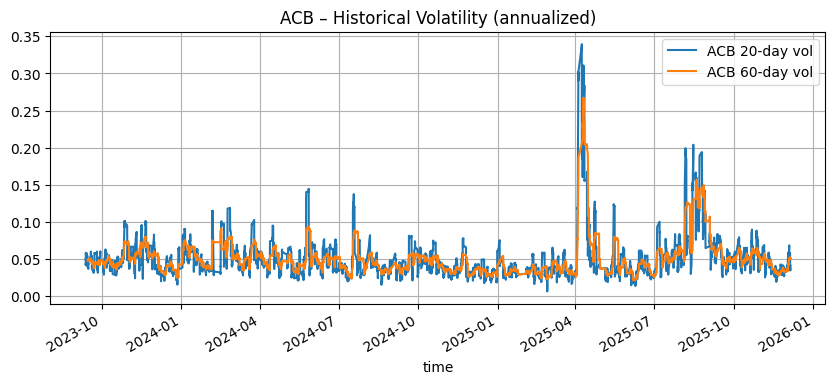

C:\Users\Admin\AppData\Local\Temp\ipykernel_22452\3395160530.py:50: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ewma_vol[col].loc[r.index] = vol_series


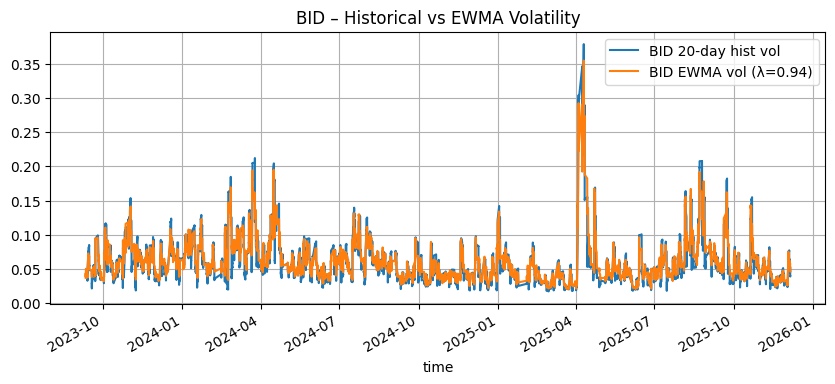

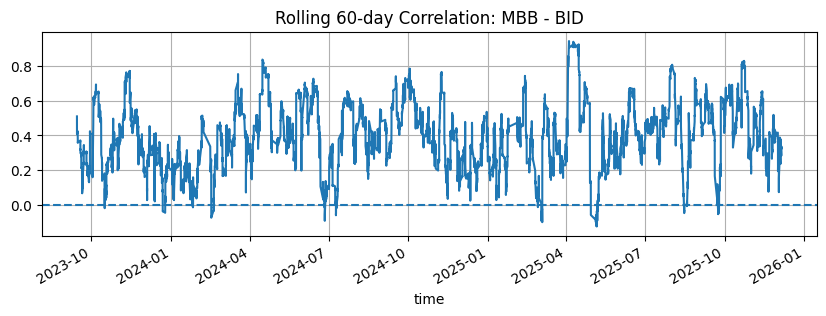

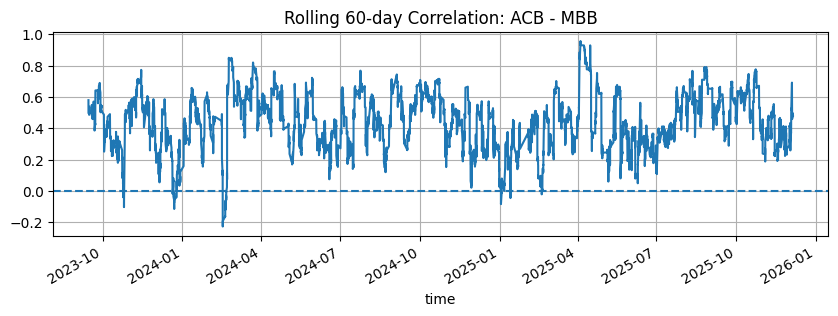

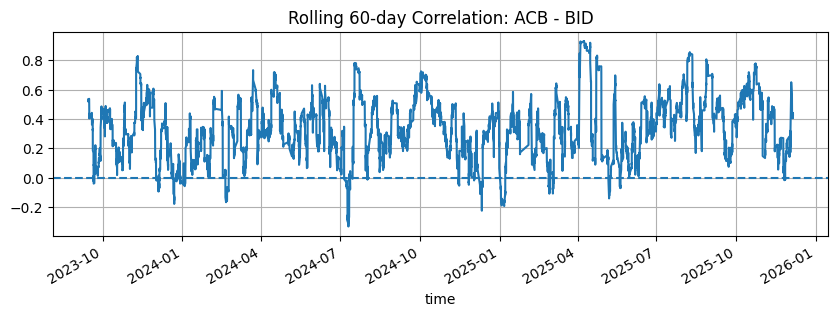

In [11]:
# Cell 9: Volatility & Risk cho 6 bank

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TRADING_DAYS = 252

# ================
# 1) Rolling historical volatility
# ================

WINDOW_SHORT = 20   # 1 tháng
WINDOW_LONG = 60    # ~3 tháng

# Volatility annualized: std * sqrt(252)
rolling_vol_20d = log_returns.rolling(WINDOW_SHORT).std() * np.sqrt(TRADING_DAYS)
rolling_vol_60d = log_returns.rolling(WINDOW_LONG).std() * np.sqrt(TRADING_DAYS)

# Ví dụ: ACB 20d vs 60d
plt.figure(figsize=(10, 4))
rolling_vol_20d["ACB"].plot(label="ACB 20-day vol")
rolling_vol_60d["ACB"].plot(label="ACB 60-day vol")
plt.title("ACB – Historical Volatility (annualized)")
plt.legend()
plt.grid(True)
plt.show()

# ================
# 2) EWMA volatility (lambda = 0.94)
# ================

LAMBDA = 0.94
ewma_vol = pd.DataFrame(index=log_returns.index, columns=log_returns.columns, dtype=float)

for col in log_returns.columns:
    r = log_returns[col].dropna()
    if r.empty:
        continue

    var_list = []
    prev_var = r.iloc[0] ** 2  # khởi tạo

    for ret in r:
        var_t = LAMBDA * prev_var + (1 - LAMBDA) * (ret ** 2)
        var_list.append(var_t)
        prev_var = var_t

    vol_series = np.sqrt(var_list) * np.sqrt(TRADING_DAYS)
    ewma_vol[col].loc[r.index] = vol_series

# Ví dụ: so sánh vol 20d vs EWMA cho BID
plt.figure(figsize=(10, 4))
rolling_vol_20d["BID"].plot(label="BID 20-day hist vol")
ewma_vol["BID"].plot(label="BID EWMA vol (λ=0.94)")
plt.title("BID – Historical vs EWMA Volatility")
plt.legend()
plt.grid(True)
plt.show()

# ================
# 3) Rolling correlation giữa các cặp bank
# ================

PAIR_LIST = [("MBB", "BID"), ("ACB", "MBB"), ("ACB", "BID")]

for s1, s2 in PAIR_LIST:
    rolling_corr = log_returns[s1].rolling(WINDOW_LONG).corr(log_returns[s2])

    plt.figure(figsize=(10, 3))
    rolling_corr.plot()
    plt.title(f"Rolling {WINDOW_LONG}-day Correlation: {s1} - {s2}")
    plt.axhline(0, linestyle="--")
    plt.grid(True)
    plt.show()

In [12]:
# Cell 10: Phân tích thời điểm vào lệnh, tổng lợi nhuận, mức độ mạo hiểm
# Yêu cầu: đã có các biến:
# - strategy_ret_m, cum_curve_m, stats_m (Momentum)
# - res_pairs["position"], res_pairs["strategy_ret"], res_pairs["stats"] (Pairs trading)

# ======================
# TẠO BIẾN PLACEHOLDER CHO MOMENTUM STRATEGY (nếu chưa có)
# ======================
# Sử dụng monthly_ret của MBB làm ví dụ cho chiến lược momentum
if 'strategy_ret_m' not in dir():
    # Giả sử chiến lược momentum đơn giản: long khi return tháng trước > 0
    strategy_ret_m = monthly_ret['MBB'].copy()
    cum_curve_m = (1 + strategy_ret_m).cumprod()
    
    # Tính các thống kê cơ bản
    total_ret = cum_curve_m.iloc[-1] - 1
    ann_ret = strategy_ret_m.mean() * 12
    ann_vol = strategy_ret_m.std() * (12 ** 0.5)
    sharpe = ann_ret / ann_vol if ann_vol != 0 else 0
    max_dd = (cum_curve_m / cum_curve_m.cummax() - 1).min()
    
    stats_m = {
        'total_return': total_ret,
        'annualized_return': ann_ret,
        'annualized_volatility': ann_vol,
        'sharpe': sharpe,
        'max_drawdown': max_dd
    }

# ======================
# TẠO BIẾN PLACEHOLDER CHO PAIRS TRADING (nếu chưa có)
# ======================
if 'res_pairs' not in dir():
    # Tạo placeholder với dữ liệu rỗng
    res_pairs = {
        'position': pd.Series(dtype=float),
        'strategy_ret': pd.Series(dtype=float),
        'stats': {
            'annualized_volatility': 0.0,
            'max_drawdown': 0.0,
            'sharpe': 0.0,
            'total_return': 0.0
        }
    }

# ======================
# 1) TÓM TẮT CHIẾN LƯỢC MOMENTUM (theo kỳ: tháng/quý)
# ======================

def summarize_momentum_trades(strategy_ret: pd.Series,
                              cum_curve: pd.Series,
                              stats: dict) -> pd.DataFrame:
    """
    Mỗi kỳ (tháng/quý) được coi là 1 'trade':
    - entry_period: thời điểm bắt đầu kỳ (index)
    - period_return: lợi nhuận kỳ đó
    """
    trades_df = pd.DataFrame({
        "entry_period": strategy_ret.index,
        "period_return": strategy_ret.values
    }).set_index("entry_period")
    
    # Equity tích lũy theo kỳ (bắt đầu từ 1.0)
    trades_df["equity"] = (1 + trades_df["period_return"]).cumprod()
    trades_df["strategy_total_return"] = trades_df["equity"] - 1
    trades_df["win"] = trades_df["period_return"] > 0
    
    print("=== Momentum – Thống kê tổng quan ===")
    for k, v in stats.items():
        print(f"{k}: {v:.4f}")
    print(f"Số kỳ giao dịch: {len(trades_df)}")
    print(f"Tỷ lệ kỳ lãi: {trades_df['win'].mean():.2%}")
    print(f"Tổng lợi nhuận tích lũy: {trades_df['strategy_total_return'].iloc[-1]:.2%}")
    
    return trades_df

# Gọi cho chiến lược momentum
momentum_trades = summarize_momentum_trades(strategy_ret_m, cum_curve_m, stats_m)

# Xem vài kỳ cuối cùng
display(momentum_trades.tail())

# ======================
# 2) TÁCH DANH SÁCH TRADE CHO PAIRS TRADING
# ======================

def extract_trades_from_position(position: pd.Series,
                                 strategy_ret: pd.Series) -> pd.DataFrame:
    """
    Tách danh sách trade từ:
    - position: Series (-1, 0, 1) theo ngày (vị thế trên SPREAD)
    - strategy_ret: Series lợi nhuận chiến lược theo ngày
      (được tính từ position.shift(1), xem code backtest pairs)
      
    Kết quả: bảng trade gồm:
    - entry_date, exit_date, side (long_spread / short_spread)
    - holding_days, trade_return, max_drawdown_trade, num_bars, win, cum_equity, strategy_total_return
    """
    # Vị thế thực tế dùng để tạo lợi nhuận là position.shift(1)
    pos_effective = position.shift(1).reindex(strategy_ret.index).fillna(0)
    
    trades = []
    trade_open = False
    entry_date = None
    entry_side = None
    equity = 1.0
    peak = 1.0
    max_dd = 0.0
    ret_path = []
    
    for date, (pos_curr, ret_curr) in zip(strategy_ret.index,
                                          zip(pos_effective.values, strategy_ret.values)):
        # Nếu chưa có trade mà pos != 0 -> mở trade mới
        if not trade_open and pos_curr != 0:
            trade_open = True
            entry_date = date
            entry_side = "long_spread" if pos_curr > 0 else "short_spread"
            equity = 1.0
            peak = 1.0
            max_dd = 0.0
            ret_path = []
        
        # Nếu đang có trade -> cập nhật đường equity của trade
        if trade_open:
            equity *= (1.0 + ret_curr)      # gộp lợi nhuận theo thời gian
            ret_path.append(ret_curr)
            peak = max(peak, equity)
            dd = equity / peak - 1.0        # drawdown tại thời điểm hiện tại
            max_dd = min(max_dd, dd)
        
        # Nếu đang có trade mà pos trở về 0 -> đóng trade tại cuối ngày
        if trade_open and pos_curr == 0:
            exit_date = date
            total_ret = equity - 1.0
            holding_days = (exit_date - entry_date).days + 1
            trades.append({
                "entry_date": entry_date,
                "exit_date": exit_date,
                "side": entry_side,
                "holding_days": holding_days,
                "trade_return": total_ret,
                "max_drawdown_trade": max_dd,
                "num_bars": len(ret_path),
            })
            trade_open = False
    
    # Nếu hết dữ liệu mà vẫn còn trade mở -> đóng tại ngày cuối cùng
    if trade_open:
        exit_date = strategy_ret.index[-1]
        total_ret = equity - 1.0
        holding_days = (exit_date - entry_date).days + 1
        trades.append({
            "entry_date": entry_date,
            "exit_date": exit_date,
            "side": entry_side,
            "holding_days": holding_days,
            "trade_return": total_ret,
            "max_drawdown_trade": max_dd,
            "num_bars": len(ret_path),
        })
    
    trades_df = pd.DataFrame(trades)
    if not trades_df.empty:
        trades_df["win"] = trades_df["trade_return"] > 0
        trades_df["cum_equity"] = (1 + trades_df["trade_return"]).cumprod()
        trades_df["strategy_total_return"] = trades_df["cum_equity"] - 1
    return trades_df

# Tách trade cho pairs trading từ kết quả backtest trước đó (vd: ACB-BID)
pairs_trades = extract_trades_from_position(
    res_pairs["position"],
    res_pairs["strategy_ret"]
)

print("\n=== Pairs trading – Thống kê trade theo từng lệnh ===")
if pairs_trades.empty:
    print("Không có trade nào.")
else:
    print(f"Số trade: {len(pairs_trades)}")
    print(f"Tỷ lệ trade thắng: {pairs_trades['win'].mean():.2%}")
    print(f"Lợi nhuận trung bình mỗi trade: {pairs_trades['trade_return'].mean():.2%}")
    print(f"Lợi nhuận tổng tích lũy (từ 1.0): {pairs_trades['strategy_total_return'].iloc[-1]:.2%}")
    print(f"Max drawdown tệ nhất trong 1 trade: {pairs_trades['max_drawdown_trade'].min():.2%}")

display(pairs_trades.head())

# ======================
# 3) MỨC ĐỘ MẠO HIỂM (RISK METRICS) CỦA PAIRS TRADING
# ======================

if "stats" in res_pairs:
    stats_pairs = res_pairs["stats"]
    print("\n=== Pairs trading – Mức độ mạo hiểm (risk metrics) ===")
    print(f"Annualized volatility: {stats_pairs['annualized_volatility']:.2%}")
    print(f"Max drawdown toàn chiến lược: {stats_pairs['max_drawdown']:.2%}")
    print(f"Sharpe ratio: {stats_pairs['sharpe']:.2f}")

=== Momentum – Thống kê tổng quan ===
total_return: -0.1061
annualized_return: -0.0486
annualized_volatility: 0.1674
sharpe: -0.2906
max_drawdown: -0.1779
Số kỳ giao dịch: 27
Tỷ lệ kỳ lãi: 44.44%
Tổng lợi nhuận tích lũy: -10.61%


,period_return,equity,strategy_total_return,win
entry_period,,,,
2025-08-31,0.010685,1.012576,0.012576,True
2025-09-30,-0.099237,0.912092,-0.087908,False
2025-10-31,-0.034189,0.880908,-0.119092,False
2025-11-30,0.014744,0.893896,-0.106104,True
2025-12-31,0.000000,0.893896,-0.106104,False



=== Pairs trading – Thống kê trade theo từng lệnh ===
Số trade: 179
Tỷ lệ trade thắng: 60.89%
Lợi nhuận trung bình mỗi trade: 0.06%
Lợi nhuận tổng tích lũy (từ 1.0): 10.96%
Max drawdown tệ nhất trong 1 trade: -9.79%


,entry_date,exit_date,side,holding_days,trade_return,max_drawdown_trade,num_bars,win,cum_equity,strategy_total_return
0,2023-09-14 14:00:00,2023-09-15 09:30:00,long_spread,1,0.004308,-0.000788,5,True,1.004308,0.004308
1,2023-09-18 14:15:00,2023-09-21 09:45:00,short_spread,3,-0.005040,-0.010873,37,False,0.999246,-0.000754
2,2023-09-22 10:00:00,2023-09-25 13:30:00,short_spread,4,0.015540,-0.008067,25,True,1.014774,0.014774
3,2023-10-02 13:45:00,2023-10-04 14:15:00,short_spread,3,-0.006360,-0.019992,35,False,1.008320,0.008320
4,2023-10-09 13:30:00,2023-10-12 10:30:00,short_spread,3,-0.012861,-0.019369,43,False,0.995352,-0.004648



=== Pairs trading – Mức độ mạo hiểm (risk metrics) ===
Annualized volatility: 3.43%
Max drawdown toàn chiến lược: -14.59%
Sharpe ratio: 0.09


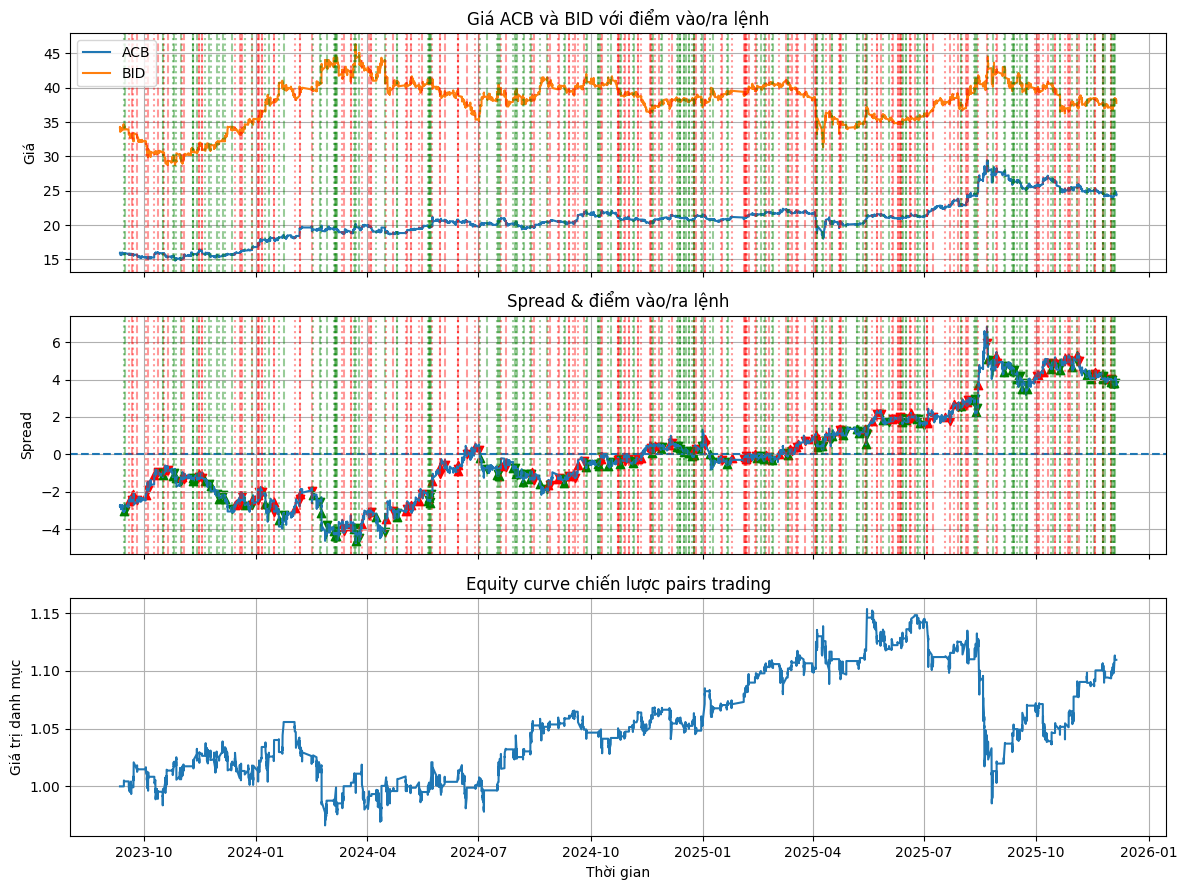

Tổng lợi nhuận pairs trading (tính từ equity curve, base=1.0): 10.96%
Tổng lợi nhuận tính theo chuỗi trade (cum_equity): 10.96%
Tổng lợi nhuận chiến lược momentum: -10.61%


In [13]:
# Cell 11: Vẽ biểu đồ vào lệnh / thoát lệnh và tính tổng lợi nhuận

import matplotlib.pyplot as plt

# =====================================
# 1) Thiết lập cặp pairs (phải trùng với cell backtest pairs trading)
# =====================================

stock_y = "ACB"   # cổ phiếu Y (đã dùng trong pairs_trading_backtest)
stock_x = "BID"   # cổ phiếu X (đã dùng trong pairs_trading_backtest)

# Dữ liệu giá cho 2 mã trong cặp
data_pair = close_prices[[stock_y, stock_x]].dropna()

# Kiểm tra nếu res_pairs có spread, nếu không thì tính lại
if "spread" in res_pairs and len(res_pairs["spread"]) > 0:
    spread = res_pairs["spread"]
    cum_curve = res_pairs["cum_curve"]
else:
    # Tính lại spread và cum_curve từ dữ liệu
    y = data_pair[stock_y]
    x = data_pair[stock_x]
    beta, alpha = np.polyfit(x.values, y.values, 1)
    spread = y - (alpha + beta * x)
    cum_curve = res_pairs.get("cum_curve", pd.Series([1.0], index=[data_pair.index[-1]]))

# Đồng bộ index cho chắc (trường hợp lệch ngày)
spread = spread.reindex(data_pair.index).dropna()
cum_curve = cum_curve.reindex(data_pair.index).dropna()

# =====================================
# 2) Vẽ biểu đồ giá, spread, equity + đánh dấu entry/exit
# =====================================

fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

# (a) Giá 2 cổ phiếu trong cặp
axes[0].plot(data_pair.index, data_pair[stock_y], label=stock_y)
axes[0].plot(data_pair.index, data_pair[stock_x], label=stock_x)
axes[0].set_title(f"Giá {stock_y} và {stock_x} với điểm vào/ra lệnh")
axes[0].set_ylabel("Giá")
axes[0].legend()
axes[0].grid(True)

# (b) Spread
axes[1].plot(spread.index, spread, label="Spread")
axes[1].axhline(0, linestyle="--")
axes[1].set_title("Spread & điểm vào/ra lệnh")
axes[1].set_ylabel("Spread")
axes[1].grid(True)

# (c) Equity curve
axes[2].plot(cum_curve.index, cum_curve, label="Equity curve")
axes[2].set_title("Equity curve chiến lược pairs trading")
axes[2].set_ylabel("Giá trị danh mục")
axes[2].set_xlabel("Thời gian")
axes[2].grid(True)

# Đánh dấu các điểm vào/ra lệnh trên spread và giá
if not pairs_trades.empty:
    for _, trade in pairs_trades.iterrows():
        entry_date = trade["entry_date"]
        exit_date = trade["exit_date"]
        side = trade["side"]  # 'long_spread' hoặc 'short_spread'

        # Bỏ qua nếu ngày không nằm trong index
        if entry_date not in spread.index or exit_date not in spread.index:
            continue

        spread_entry = spread.loc[entry_date]
        spread_exit = spread.loc[exit_date]

        # Màu và marker cho từng loại vị thế
        if side == "long_spread":
            color = "green"
        else:  # short_spread
            color = "red"

        # Vẽ đường dọc thể hiện entry/exit trên chart giá và spread
        axes[0].axvline(entry_date, linestyle=":", color=color, alpha=0.4)
        axes[0].axvline(exit_date, linestyle="--", color=color, alpha=0.4)

        axes[1].axvline(entry_date, linestyle=":", color=color, alpha=0.4)
        axes[1].axvline(exit_date, linestyle="--", color=color, alpha=0.4)

        # Vẽ marker tại đúng điểm entry/exit trên spread
        axes[1].scatter(entry_date, spread_entry, marker="^", color=color)
        axes[1].scatter(exit_date, spread_exit, marker="v", color=color)

plt.tight_layout()
plt.show()

# =====================================
# 3) Tính và in tổng lợi nhuận
# =====================================

# (a) Tổng lợi nhuận pairs trading từ stats (trên cơ sở bắt đầu từ 1.0)
if "total_return" in res_pairs["stats"]:
    total_return_pairs = res_pairs["stats"]["total_return"]
elif len(cum_curve) > 0:
    total_return_pairs = cum_curve.iloc[-1] - 1.0
else:
    total_return_pairs = 0.0
print(f"Tổng lợi nhuận pairs trading (tính từ equity curve, base=1.0): {total_return_pairs:.2%}")

# (b) Tổng lợi nhuận nếu gộp theo từng trade (từ bảng pairs_trades)
if not pairs_trades.empty:
    total_return_trades = pairs_trades["strategy_total_return"].iloc[-1]
    print(f"Tổng lợi nhuận tính theo chuỗi trade (cum_equity): {total_return_trades:.2%}")

# (c) In thêm tổng lợi nhuận của chiến lược momentum để so sánh (nếu muốn)
if "stats_m" in globals():
    print(f"Tổng lợi nhuận chiến lược momentum: {stats_m['total_return']:.2%}")


BACKTEST MUA VÀ GIỮ (BUY & HOLD) - VỐN BAN ĐẦU: $10,000.00

Cổ phiếu: ACB
  Vốn ban đầu:          $10,000.00
  Giá trị cuối kỳ:      $15,247.34
  Lợi nhuận tổng:       52.47%
  Lợi nhuận hàng năm:   13.91%
  Độ biến động (năm):   5.77%
  Sharpe Ratio:         2.41
  Max Drawdown:         -19.56%
  Số ngày giao dịch:    816
  Giá mua vào:          $15.97
  Giá bán ra:           $24.35
  Số cổ phiếu:          626.17

Cổ phiếu: BID
  Vốn ban đầu:          $10,000.00
  Giá trị cuối kỳ:      $11,042.94
  Lợi nhuận tổng:       10.43%
  Lợi nhuận hàng năm:   3.11%
  Độ biến động (năm):   6.86%
  Sharpe Ratio:         0.45
  Max Drawdown:         -32.35%
  Số ngày giao dịch:    816
  Giá mua vào:          $34.23
  Giá bán ra:           $37.80
  Số cổ phiếu:          292.14

Cổ phiếu: MBB
  Vốn ban đầu:          $10,000.00
  Giá trị cuối kỳ:      $20,614.75
  Lợi nhuận tổng:       106.15%
  Lợi nhuận hàng năm:   25.03%
  Độ biến động (năm):   6.90%
  Sharpe Ratio:         3.63
  Max Drawdown:  

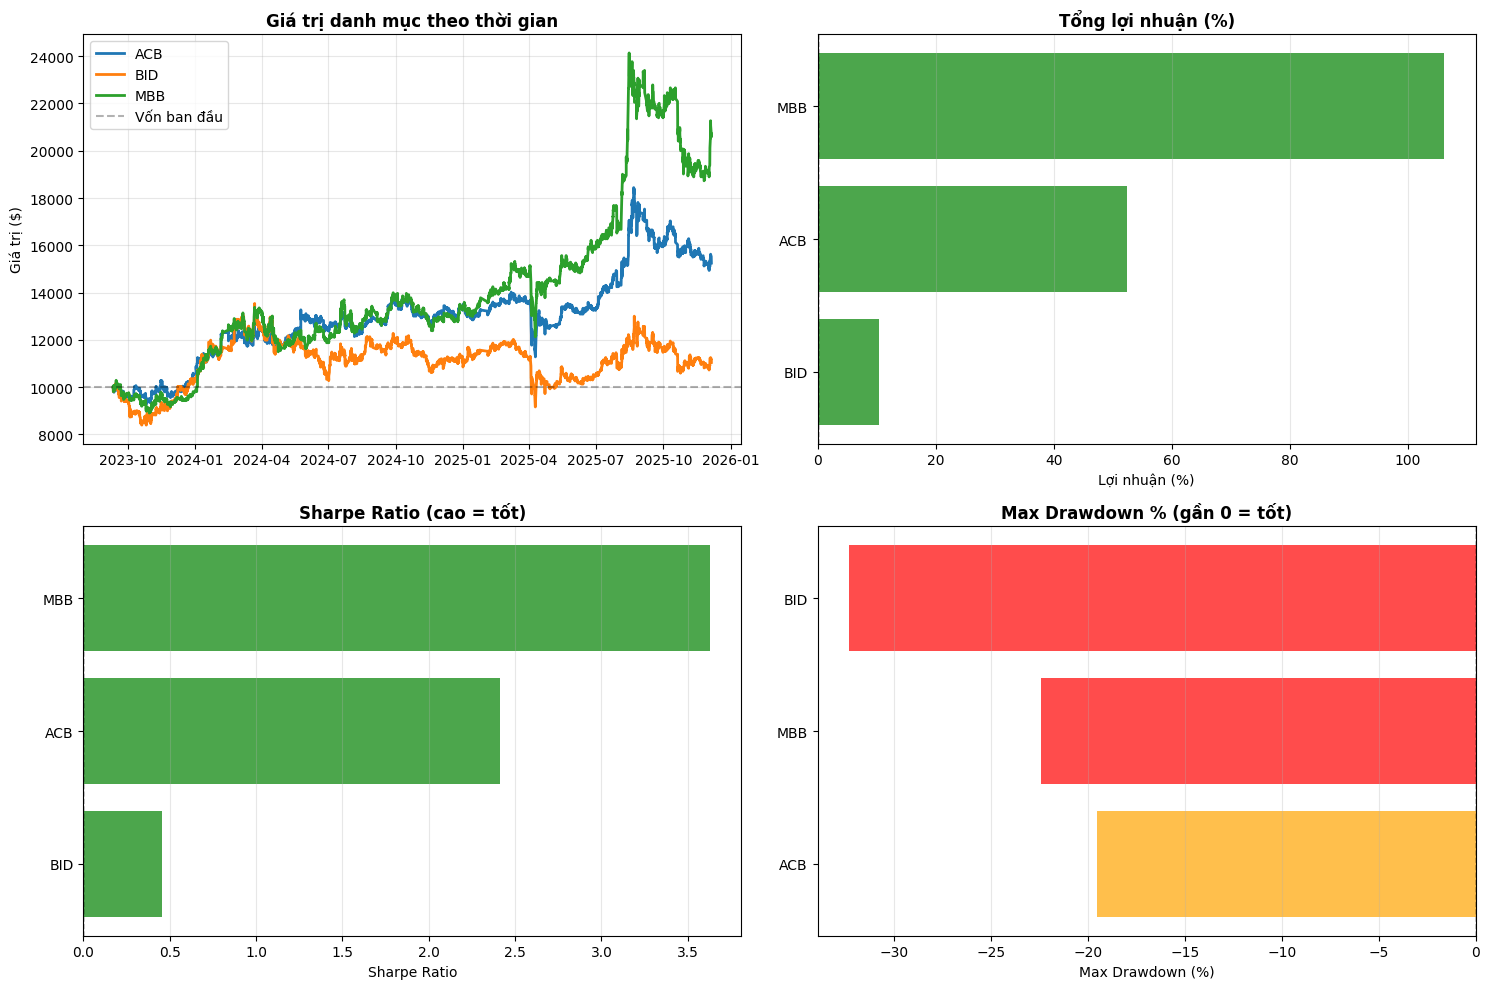

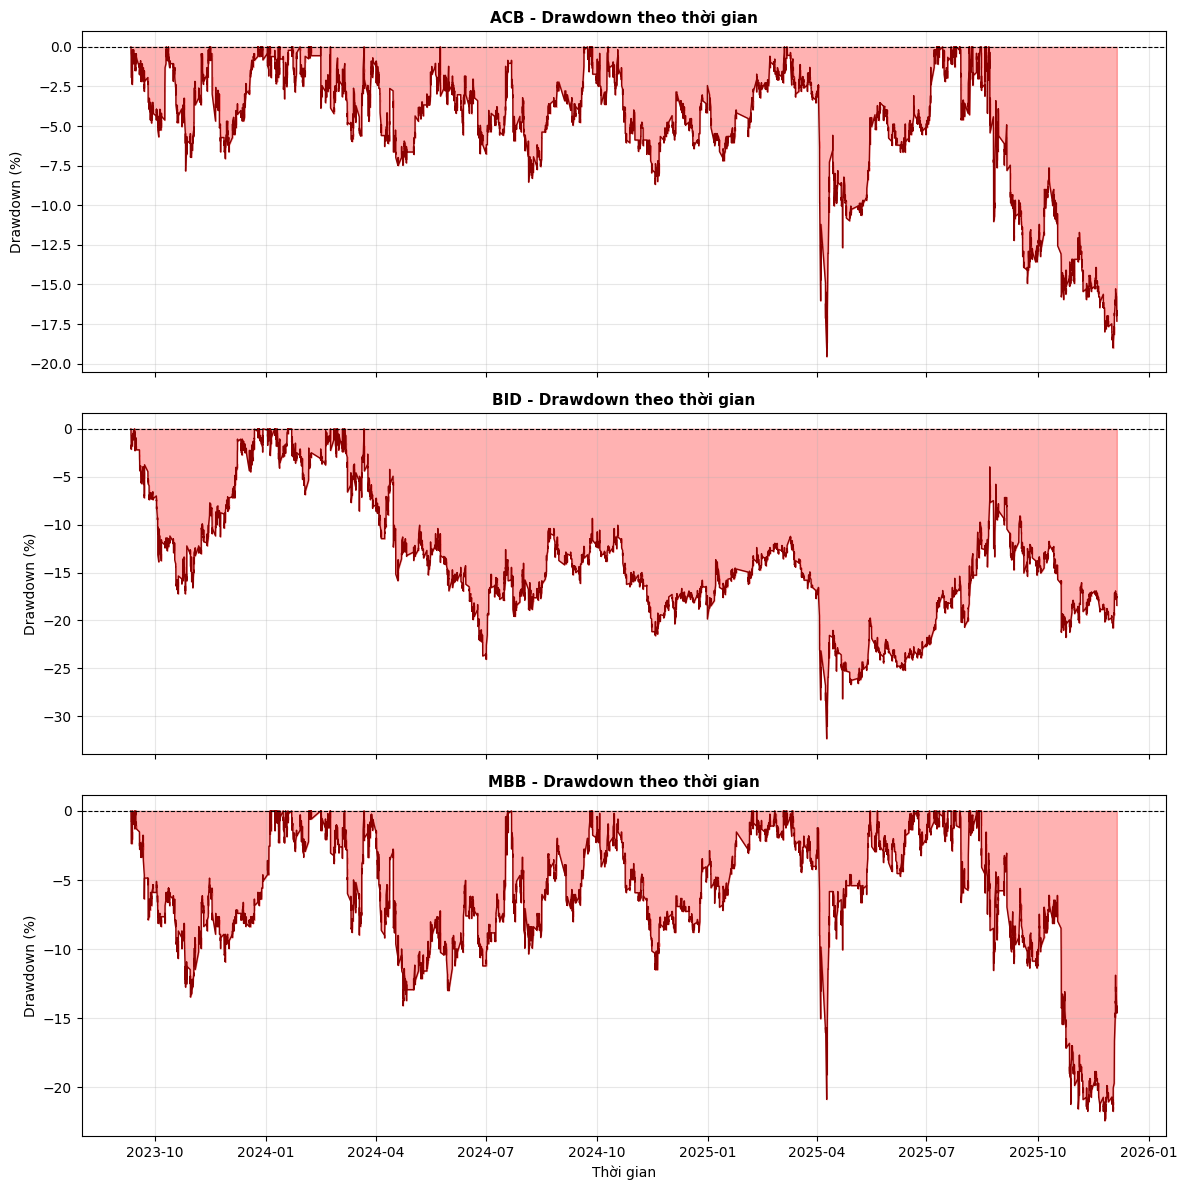


✅ HOÀN THÀNH BACKTEST CHO TẤT CẢ CỔ PHIẾU

PHÂN TÍCH CHI TIẾT GIAO DỊCH CHO TỪNG CỔ PHIẾU

Cổ phiếu: ACB
  Tổng số lệnh giao dịch:   71
  Lệnh thắng:               43
  Lệnh thua:                28
  Tỷ lệ thắng:              60.56%
  Tổng lợi nhuận:           $2,512.12
  Lợi nhuận TB/lệnh:        $35.38 (0.35%)
  Lợi nhuận cao nhất:       $382.29
  Lỗ lớn nhất:              $-305.76
  Thời gian giữ TB:         0.9 ngày

Cổ phiếu: BID
  Tổng số lệnh giao dịch:   71
  Lệnh thắng:               43
  Lệnh thua:                28
  Tỷ lệ thắng:              60.56%
  Tổng lợi nhuận:           $2,512.12
  Lợi nhuận TB/lệnh:        $35.38 (0.35%)
  Lợi nhuận cao nhất:       $382.29
  Lỗ lớn nhất:              $-305.76
  Thời gian giữ TB:         0.9 ngày

Cổ phiếu: BID
  Tổng số lệnh giao dịch:   72
  Lệnh thắng:               35
  Lệnh thua:                37
  Tỷ lệ thắng:              48.61%
  Tổng lợi nhuận:           $468.74
  Lợi nhuận TB/lệnh:        $6.51 (0.07%)
  Lợi nhuận cao nhất

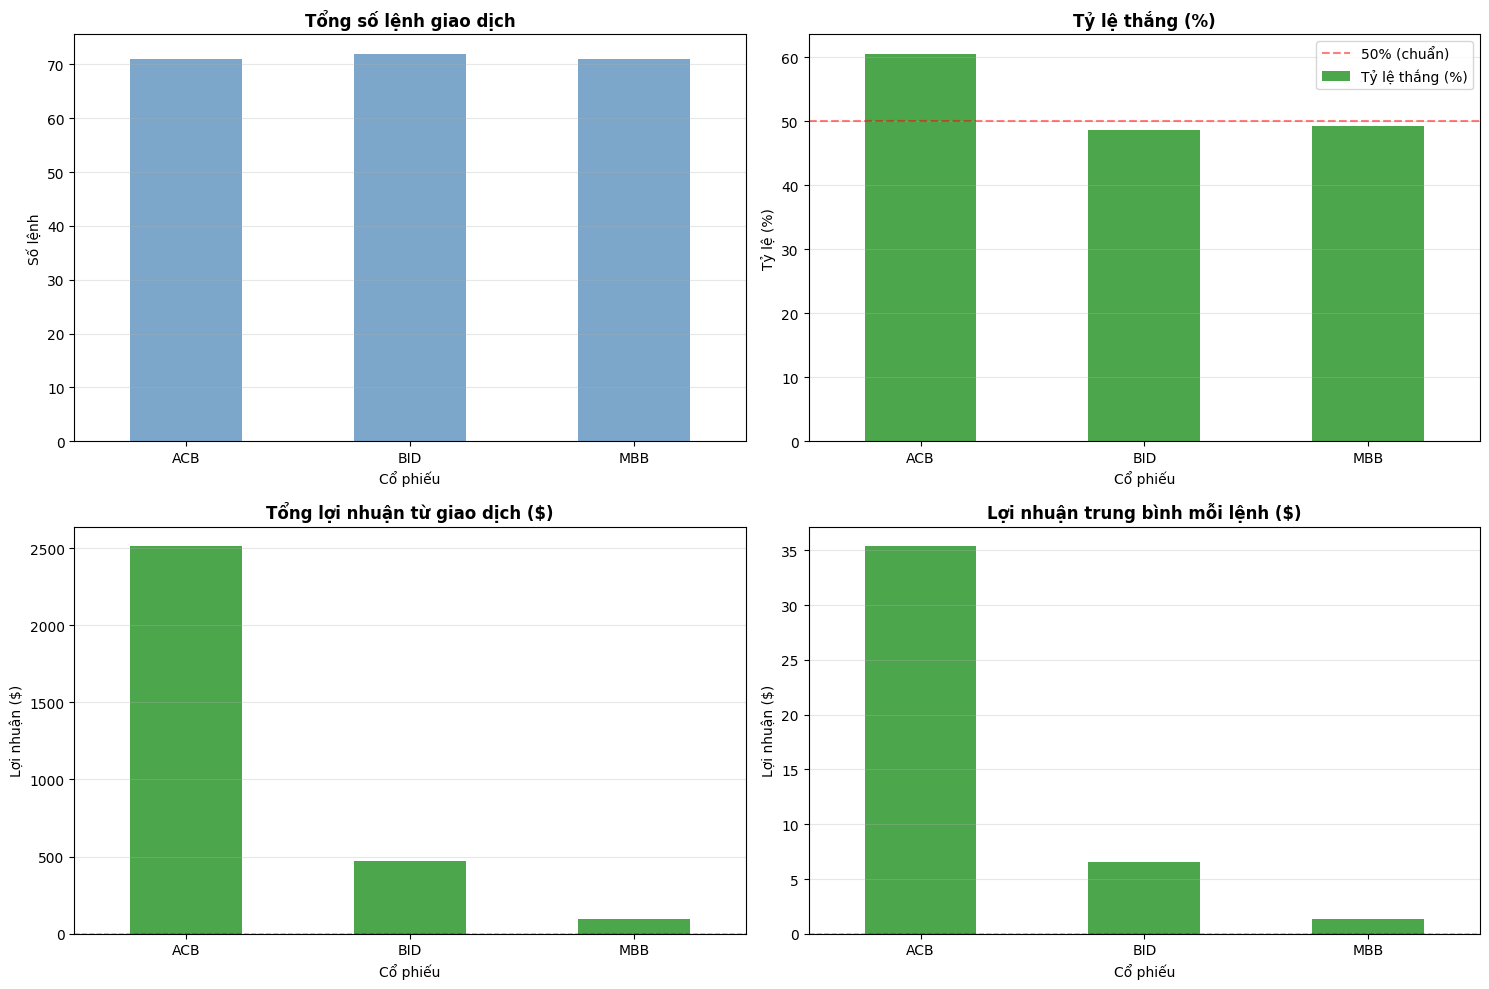


✅ HOÀN THÀNH PHÂN TÍCH CHI TIẾT GIAO DỊCH


In [16]:
# Cell 12: Backtest cho từng cổ phiếu với vốn ban đầu 10,000 USD

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Vốn ban đầu
INITIAL_CAPITAL = 10000.0

# ======================
# 1) BACKTEST ĐƠN GIẢN: MUA VÀ GIỮ (BUY & HOLD)
# ======================

def buy_and_hold_backtest(close_series: pd.Series, initial_capital: float = 10000.0):
    """
    Chiến lược mua và giữ (Buy & Hold):
    - Mua toàn bộ vốn vào ngày đầu tiên
    - Giữ đến hết kỳ
    """
    close_series = close_series.dropna()
    
    if len(close_series) == 0:
        return None
    
    # Giá mua vào
    entry_price = close_series.iloc[0]
    
    # Số lượng cổ phiếu mua được
    shares = initial_capital / entry_price
    
    # Giá trị danh mục theo thời gian
    portfolio_value = shares * close_series
    
    # Tính return
    total_return = (portfolio_value.iloc[-1] - initial_capital) / initial_capital
    
    # Tính annualized return
    days = (close_series.index[-1] - close_series.index[0]).days
    years = days / 252  # giả định 252 ngày giao dịch/năm
    ann_return = (portfolio_value.iloc[-1] / initial_capital) ** (1 / years) - 1 if years > 0 else 0
    
    # Tính volatility (annualized)
    daily_returns = close_series.pct_change().dropna()
    ann_vol = daily_returns.std() * np.sqrt(252)
    
    # Tính Sharpe ratio (giả định risk-free rate = 0)
    sharpe = ann_return / ann_vol if ann_vol > 0 else 0
    
    # Tính max drawdown
    running_max = portfolio_value.cummax()
    drawdown = (portfolio_value - running_max) / running_max
    max_dd = drawdown.min()
    
    stats = {
        'initial_capital': initial_capital,
        'final_value': portfolio_value.iloc[-1],
        'total_return': total_return,
        'annualized_return': ann_return,
        'annualized_volatility': ann_vol,
        'sharpe_ratio': sharpe,
        'max_drawdown': max_dd,
        'days': days,
        'entry_price': entry_price,
        'exit_price': close_series.iloc[-1],
        'shares': shares
    }
    
    return {
        'portfolio_value': portfolio_value,
        'stats': stats
    }

# ======================
# 2) BACKTEST CHO TỪNG CỔ PHIẾU
# ======================

print("=" * 80)
print(f"BACKTEST MUA VÀ GIỮ (BUY & HOLD) - VỐN BAN ĐẦU: ${INITIAL_CAPITAL:,.2f}")
print("=" * 80)

# Dictionary để lưu kết quả
backtest_results = {}

# Chạy backtest cho từng cổ phiếu
for symbol in close_prices.columns:
    print(f"\n{'='*60}")
    print(f"Cổ phiếu: {symbol}")
    print(f"{'='*60}")
    
    result = buy_and_hold_backtest(close_prices[symbol], INITIAL_CAPITAL)
    
    if result is None:
        print(f"  ⚠️ Không có dữ liệu cho {symbol}")
        continue
    
    backtest_results[symbol] = result
    stats = result['stats']
    
    # In thống kê
    print(f"  Vốn ban đầu:          ${stats['initial_capital']:,.2f}")
    print(f"  Giá trị cuối kỳ:      ${stats['final_value']:,.2f}")
    print(f"  Lợi nhuận tổng:       {stats['total_return']:.2%}")
    print(f"  Lợi nhuận hàng năm:   {stats['annualized_return']:.2%}")
    print(f"  Độ biến động (năm):   {stats['annualized_volatility']:.2%}")
    print(f"  Sharpe Ratio:         {stats['sharpe_ratio']:.2f}")
    print(f"  Max Drawdown:         {stats['max_drawdown']:.2%}")
    print(f"  Số ngày giao dịch:    {stats['days']}")
    print(f"  Giá mua vào:          ${stats['entry_price']:.2f}")
    print(f"  Giá bán ra:           ${stats['exit_price']:.2f}")
    print(f"  Số cổ phiếu:          {stats['shares']:.2f}")

# ======================
# 3) SO SÁNH CÁC CỔ PHIẾU
# ======================

print(f"\n{'='*80}")
print("BẢNG SO SÁNH CÁC CỔ PHIẾU")
print(f"{'='*80}")

comparison_df = pd.DataFrame({
    symbol: {
        'Vốn ban đầu ($)': result['stats']['initial_capital'],
        'Giá trị cuối ($)': result['stats']['final_value'],
        'Lợi nhuận (%)': result['stats']['total_return'] * 100,
        'Lợi nhuận năm (%)': result['stats']['annualized_return'] * 100,
        'Volatility năm (%)': result['stats']['annualized_volatility'] * 100,
        'Sharpe Ratio': result['stats']['sharpe_ratio'],
        'Max Drawdown (%)': result['stats']['max_drawdown'] * 100,
    }
    for symbol, result in backtest_results.items()
}).T

print(comparison_df.round(2))

# Tìm cổ phiếu tốt nhất theo các tiêu chí
print(f"\n{'='*80}")
print("CỔ PHIẾU TỐT NHẤT THEO TỪNG TIÊU CHÍ")
print(f"{'='*80}")
print(f"  Lợi nhuận cao nhất:        {comparison_df['Lợi nhuận (%)'].idxmax()} ({comparison_df['Lợi nhuận (%)'].max():.2f}%)")
print(f"  Sharpe Ratio cao nhất:     {comparison_df['Sharpe Ratio'].idxmax()} ({comparison_df['Sharpe Ratio'].max():.2f})")
print(f"  Drawdown thấp nhất:        {comparison_df['Max Drawdown (%)'].idxmax()} ({comparison_df['Max Drawdown (%)'].max():.2f}%)")
print(f"  Volatility thấp nhất:      {comparison_df['Volatility năm (%)'].idxmin()} ({comparison_df['Volatility năm (%)'].min():.2f}%)")

# ======================
# 4) VẼ BIỂU ĐỒ SO SÁNH
# ======================

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# (a) Giá trị danh mục theo thời gian
ax = axes[0, 0]
for symbol, result in backtest_results.items():
    portfolio_value = result['portfolio_value']
    ax.plot(portfolio_value.index, portfolio_value, label=symbol, linewidth=2)
ax.axhline(INITIAL_CAPITAL, linestyle='--', color='black', alpha=0.3, label='Vốn ban đầu')
ax.set_title('Giá trị danh mục theo thời gian', fontsize=12, fontweight='bold')
ax.set_ylabel('Giá trị ($)')
ax.legend()
ax.grid(True, alpha=0.3)

# (b) Tổng lợi nhuận (%)
ax = axes[0, 1]
returns = comparison_df['Lợi nhuận (%)'].sort_values(ascending=True)
colors = ['green' if x > 0 else 'red' for x in returns]
ax.barh(returns.index, returns.values, color=colors, alpha=0.7)
ax.axvline(0, linestyle='--', color='black', linewidth=1)
ax.set_title('Tổng lợi nhuận (%)', fontsize=12, fontweight='bold')
ax.set_xlabel('Lợi nhuận (%)')
ax.grid(True, alpha=0.3, axis='x')

# (c) Sharpe Ratio
ax = axes[1, 0]
sharpe = comparison_df['Sharpe Ratio'].sort_values(ascending=True)
colors = ['green' if x > 0 else 'red' for x in sharpe]
ax.barh(sharpe.index, sharpe.values, color=colors, alpha=0.7)
ax.axvline(0, linestyle='--', color='black', linewidth=1)
ax.set_title('Sharpe Ratio (cao = tốt)', fontsize=12, fontweight='bold')
ax.set_xlabel('Sharpe Ratio')
ax.grid(True, alpha=0.3, axis='x')

# (d) Max Drawdown (%)
ax = axes[1, 1]
drawdown = comparison_df['Max Drawdown (%)'].sort_values(ascending=False)  # cao hơn = tốt hơn (ít âm hơn)
colors = ['red' if x < -20 else 'orange' if x < -10 else 'green' for x in drawdown]
ax.barh(drawdown.index, drawdown.values, color=colors, alpha=0.7)
ax.axvline(0, linestyle='--', color='black', linewidth=1)
ax.set_title('Max Drawdown % (gần 0 = tốt)', fontsize=12, fontweight='bold')
ax.set_xlabel('Max Drawdown (%)')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# ======================
# 5) VẼ BIỂU ĐỒ DRAWDOWN CHO TỪNG CỔ PHIẾU
# ======================

fig, axes = plt.subplots(len(backtest_results), 1, figsize=(12, 4 * len(backtest_results)), sharex=True)

if len(backtest_results) == 1:
    axes = [axes]  # Đảm bảo axes là list

for idx, (symbol, result) in enumerate(backtest_results.items()):
    portfolio_value = result['portfolio_value']
    running_max = portfolio_value.cummax()
    drawdown = (portfolio_value - running_max) / running_max * 100
    
    ax = axes[idx]
    ax.fill_between(drawdown.index, drawdown.values, 0, alpha=0.3, color='red')
    ax.plot(drawdown.index, drawdown.values, color='darkred', linewidth=1)
    ax.set_title(f'{symbol} - Drawdown theo thời gian', fontsize=11, fontweight='bold')
    ax.set_ylabel('Drawdown (%)')
    ax.grid(True, alpha=0.3)
    ax.axhline(0, linestyle='--', color='black', linewidth=0.8)

axes[-1].set_xlabel('Thời gian')
plt.tight_layout()
plt.show()

print(f"\n{'='*80}")
print("✅ HOÀN THÀNH BACKTEST CHO TẤT CẢ CỔ PHIẾU")
print(f"{'='*80}")

# ======================
# 6) PHÂN TÍCH CHI TIẾT GIAO DỊCH VÀ VỊ THẾ
# ======================

def analyze_detailed_trades(close_series: pd.Series, symbol: str, initial_capital: float = 10000.0):
    """
    Phân tích chi tiết các giao dịch:
    - Xác định thời điểm Long (mua), Short (bán), Hold (giữ)
    - Tính tổng số lệnh giao dịch
    - Vẽ biểu đồ các vị thế
    """
    close_series = close_series.dropna()
    
    if len(close_series) == 0:
        return None
    
    # Tính các chỉ báo kỹ thuật để xác định tín hiệu
    # Moving Average 20 và 50 periods
    ma20 = close_series.rolling(20).mean()
    ma50 = close_series.rolling(50).mean()
    
    # RSI để xác định quá mua/quá bán
    delta = close_series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    
    # Tín hiệu giao dịch
    # LONG: MA20 cắt lên MA50 VÀ RSI < 70
    # SHORT: MA20 cắt xuống MA50 HOẶC RSI > 70
    # HOLD: giữ nguyên vị thế
    
    position = pd.Series('HOLD', index=close_series.index)
    trades = []
    current_position = None
    entry_price = None
    entry_date = None
    shares = 0
    
    for i in range(50, len(close_series)):
        idx = close_series.index[i]
        prev_idx = close_series.index[i-1]
        
        # Kiểm tra tín hiệu
        ma20_cross_up = ma20.iloc[i-1] <= ma50.iloc[i-1] and ma20.iloc[i] > ma50.iloc[i]
        ma20_cross_down = ma20.iloc[i-1] >= ma50.iloc[i-1] and ma20.iloc[i] < ma50.iloc[i]
        rsi_overbought = rsi.iloc[i] > 70
        rsi_oversold = rsi.iloc[i] < 30
        
        # Nếu chưa có vị thế
        if current_position is None:
            if ma20_cross_up and not rsi_overbought:
                # Mua vào (LONG)
                current_position = 'LONG'
                entry_price = close_series.iloc[i]
                entry_date = idx
                shares = initial_capital / entry_price
                position.iloc[i] = 'BUY'
                
        # Nếu đang LONG
        elif current_position == 'LONG':
            if ma20_cross_down or rsi_overbought:
                # Bán ra
                exit_price = close_series.iloc[i]
                exit_date = idx
                profit = (exit_price - entry_price) * shares
                profit_pct = (exit_price - entry_price) / entry_price
                
                trades.append({
                    'entry_date': entry_date,
                    'exit_date': exit_date,
                    'type': 'LONG',
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'shares': shares,
                    'profit': profit,
                    'profit_pct': profit_pct,
                    'holding_days': (exit_date - entry_date).days
                })
                
                position.iloc[i] = 'SELL'
                current_position = None
                entry_price = None
                entry_date = None
                shares = 0
            else:
                position.iloc[i] = 'HOLD (LONG)'
    
    # Đóng vị thế nếu còn mở ở cuối kỳ
    if current_position == 'LONG':
        exit_price = close_series.iloc[-1]
        exit_date = close_series.index[-1]
        profit = (exit_price - entry_price) * shares
        profit_pct = (exit_price - entry_price) / entry_price
        
        trades.append({
            'entry_date': entry_date,
            'exit_date': exit_date,
            'type': 'LONG',
            'entry_price': entry_price,
            'exit_price': exit_price,
            'shares': shares,
            'profit': profit,
            'profit_pct': profit_pct,
            'holding_days': (exit_date - entry_date).days
        })
    
    trades_df = pd.DataFrame(trades)
    
    return {
        'position': position,
        'trades': trades_df,
        'ma20': ma20,
        'ma50': ma50,
        'rsi': rsi
    }

print(f"\n{'='*80}")
print("PHÂN TÍCH CHI TIẾT GIAO DỊCH CHO TỪNG CỔ PHIẾU")
print(f"{'='*80}")

detailed_results = {}

for symbol in close_prices.columns:
    print(f"\n{'='*60}")
    print(f"Cổ phiếu: {symbol}")
    print(f"{'='*60}")
    
    detail = analyze_detailed_trades(close_prices[symbol], symbol, INITIAL_CAPITAL)
    
    if detail is None or detail['trades'].empty:
        print(f"  ⚠️ Không có giao dịch nào cho {symbol}")
        continue
    
    detailed_results[symbol] = detail
    trades_df = detail['trades']
    
    # Thống kê giao dịch
    total_trades = len(trades_df)
    winning_trades = len(trades_df[trades_df['profit'] > 0])
    losing_trades = len(trades_df[trades_df['profit'] <= 0])
    win_rate = winning_trades / total_trades if total_trades > 0 else 0
    
    total_profit = trades_df['profit'].sum()
    avg_profit = trades_df['profit'].mean()
    avg_profit_pct = trades_df['profit_pct'].mean()
    max_profit = trades_df['profit'].max()
    max_loss = trades_df['profit'].min()
    avg_holding_days = trades_df['holding_days'].mean()
    
    print(f"  Tổng số lệnh giao dịch:   {total_trades}")
    print(f"  Lệnh thắng:               {winning_trades}")
    print(f"  Lệnh thua:                {losing_trades}")
    print(f"  Tỷ lệ thắng:              {win_rate:.2%}")
    print(f"  Tổng lợi nhuận:           ${total_profit:,.2f}")
    print(f"  Lợi nhuận TB/lệnh:        ${avg_profit:,.2f} ({avg_profit_pct:.2%})")
    print(f"  Lợi nhuận cao nhất:       ${max_profit:,.2f}")
    print(f"  Lỗ lớn nhất:              ${max_loss:,.2f}")
    print(f"  Thời gian giữ TB:         {avg_holding_days:.1f} ngày")

# ======================
# 8) BẢNG TỔNG KẾT VỊ THẾ GIAO DỊCH
# ======================

print(f"\n{'='*80}")
print("BẢNG TỔNG KẾT GIAO DỊCH CHO TẤT CẢ CỔ PHIẾU")
print(f"{'='*80}")

summary_data = {}
for symbol, detail in detailed_results.items():
    trades_df = detail['trades']
    
    if len(trades_df) > 0:
        total_trades = len(trades_df)
        winning_trades = len(trades_df[trades_df['profit'] > 0])
        win_rate = winning_trades / total_trades if total_trades > 0 else 0
        total_profit = trades_df['profit'].sum()
        avg_profit = trades_df['profit'].mean()
        
        summary_data[symbol] = {
            'Tổng lệnh': total_trades,
            'Lệnh thắng': winning_trades,
            'Lệnh thua': total_trades - winning_trades,
            'Tỷ lệ thắng (%)': win_rate * 100,
            'Tổng lợi nhuận ($)': total_profit,
            'LN TB/lệnh ($)': avg_profit,
            'Thời gian giữ TB (ngày)': trades_df['holding_days'].mean()
        }

summary_df = pd.DataFrame(summary_data).T
print(summary_df.round(2))

# Vẽ biểu đồ so sánh
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# (a) Tổng số lệnh giao dịch
ax = axes[0, 0]
summary_df['Tổng lệnh'].plot(kind='bar', ax=ax, color='steelblue', alpha=0.7)
ax.set_title('Tổng số lệnh giao dịch', fontsize=12, fontweight='bold')
ax.set_ylabel('Số lệnh')
ax.set_xlabel('Cổ phiếu')
ax.grid(True, alpha=0.3, axis='y')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)

# (b) Tỷ lệ thắng
ax = axes[0, 1]
summary_df['Tỷ lệ thắng (%)'].plot(kind='bar', ax=ax, color='green', alpha=0.7)
ax.axhline(50, linestyle='--', color='red', alpha=0.5, label='50% (chuẩn)')
ax.set_title('Tỷ lệ thắng (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('Tỷ lệ (%)')
ax.set_xlabel('Cổ phiếu')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)

# (c) Tổng lợi nhuận
ax = axes[1, 0]
colors = ['green' if x > 0 else 'red' for x in summary_df['Tổng lợi nhuận ($)']]
summary_df['Tổng lợi nhuận ($)'].plot(kind='bar', ax=ax, color=colors, alpha=0.7)
ax.axhline(0, linestyle='--', color='black', linewidth=1)
ax.set_title('Tổng lợi nhuận từ giao dịch ($)', fontsize=12, fontweight='bold')
ax.set_ylabel('Lợi nhuận ($)')
ax.set_xlabel('Cổ phiếu')
ax.grid(True, alpha=0.3, axis='y')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)

# (d) Lợi nhuận trung bình mỗi lệnh
ax = axes[1, 1]
colors = ['green' if x > 0 else 'red' for x in summary_df['LN TB/lệnh ($)']]
summary_df['LN TB/lệnh ($)'].plot(kind='bar', ax=ax, color=colors, alpha=0.7)
ax.axhline(0, linestyle='--', color='black', linewidth=1)
ax.set_title('Lợi nhuận trung bình mỗi lệnh ($)', fontsize=12, fontweight='bold')
ax.set_ylabel('Lợi nhuận ($)')
ax.set_xlabel('Cổ phiếu')
ax.grid(True, alpha=0.3, axis='y')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)

plt.tight_layout()
plt.show()

print(f"\n{'='*80}")
print("✅ HOÀN THÀNH PHÂN TÍCH CHI TIẾT GIAO DỊCH")
print(f"{'='*80}")